# Data - How Institutions of Higher Education Can Mine The Key Ingredient of  A Successful Analytics Program

The development of data analytics programs that foster robust decision support systems have become a key component of strategic initiatives for institutions of higher-education. However, college and university leadership teams remain unsure of how to effectively incorporate analytics into the institution's operations.

The object of this project is to explore the power of a predictive system based on the notion that at the end of each semester we can diagnose the chances of a student graduating in 4 years based on all available information up to that point. 

One main objective is to identify an information saturation point upon which actionable intervention is implemented. The hypothesis is that there exists a local maxima saturation point which provides the most appropriate intervention point.

# Tools

In [1]:
# General
from __future__ import print_function, division
import sys

# Database
import cx_Oracle
from sqlalchemy import create_engine
from getpass import getpass

# Tools
import pandas as pd
import seaborn as sns
import random
import string
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
import time
#import pandas_profiling

pd.options.display.max_columns = None

# Analytics
#import pymc3 as pm
from scipy.stats import beta

#IMBALANCED DATA
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#SciKitLearn Models
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier #(wait for scikit release 18.0)
from sklearn.neighbors import KNeighborsClassifier

#XgBoost Model ###################################################################################
# import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
##################################################################################################

#MODEL SELECTION, #EVALUATION METRICS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# Academic Data: Performance & Demographics

#### Grades Data
First we obtain the students grades along with a few variables. The goal is to aggregate the grade records to a semester summary.

In [2]:
username = input('Enter username: ')

password = getpass(prompt='Enter password: ')

Enter username: japitz
Enter password: ········


In [3]:
service_name = 'iraarch'
host = 'ira-oradb01.its.csulb.edu'
port = '1521'
grades_query = 'grd.sql'
dem_query = 'dae.sql'

def db_query(username, password, service_name, host, port, query):

    dsn = cx_Oracle.makedsn(host, port, service_name=service_name)

    cstr = 'oracle://{user}:{password}@{dsn}'.format(
        user=username,
        password=password,
        dsn=dsn
    )

    engine =  create_engine(
        cstr,
        convert_unicode=False,
        pool_recycle=10,
        pool_size=50,
    )

    with open(query, 'r') as f:
        data=f.read()#.replace('\n', '')
        
    return (data, engine)

In [5]:
grades, engine = db_query(username, password, service_name, host, port, grades_query)
grd = pd.read_sql(grades, engine)

demo, engine = db_query(username, password, service_name, host, port, dem_query)
dem = pd.read_sql(demo, engine)


print(grd.shape)
print(dem.shape)

(300329, 39)
(4276, 24)


In [6]:
grd.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300329 entries, 0 to 300328
Data columns (total 39 columns):
cohort                     300329 non-null object
emplid                     300329 non-null object
term_code                  300329 non-null object
class_term                 300329 non-null object
session_code               300329 non-null object
eot_acad_career            300329 non-null object
eot_program_cd             300329 non-null object
eot_program                300329 non-null object
eot_college_cd             300298 non-null object
eot_college                300298 non-null object
eot_department_cd          300298 non-null object
eot_department             300298 non-null object
eot_acad_plan_cd           300329 non-null object
eot_acad_plan              300329 non-null object
class_college_code         300260 non-null object
class_college              300260 non-null object
class_dept_code            300260 non-null object
class_dept                 300260 non-n

In [7]:
dem.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4276 entries, 0 to 4275
Data columns (total 24 columns):
emplid                   4276 non-null object
dem_cohort               4276 non-null object
dem_diff_indx            2947 non-null float64
dae_emplid               4276 non-null object
gender                   4276 non-null object
ethnicity                4276 non-null object
first_generation         4276 non-null object
dep_family_size          4276 non-null object
minority                 4276 non-null object
applicant_family_size    4276 non-null object
applicant_income         4276 non-null object
pelltot_emplid           2467 non-null object
pell_eligibility         2467 non-null object
esa_emplid               4276 non-null object
act_comp                 1426 non-null float64
act_read                 1426 non-null float64
act_math                 1426 non-null float64
act_eng                  1425 non-null float64
act_sci                  1426 non-null float64
sat_read     

In [8]:
#Change 'UNKNOWN' to more unique string to avoid having columns with same name after one-hot-encode

dem['first_generation'] = dem['first_generation'].apply(lambda x: 'First Generation Unknown' if x == 'UNKNOWN' else x)
dem['ethnicity'] = dem['ethnicity'].apply(lambda x: 'ETHNICITY UNKNOWN' if x == 'UNKNOWN' else x)

##### Create Training and Test/Validation Sets of Students at this stage to avoid leakeage 

In [9]:
students = pd.DataFrame(grd['emplid'].unique(), columns=['emplid'])

print('there are {} students'.format(students.shape[0]))

there are 8216 students


##### Create the Grades Trainning and Validation Student Set

In [10]:
students_train, students_dev = train_test_split(students, test_size=0.10, random_state=42)

students_train = pd.DataFrame(students_train)

students_dev = pd.DataFrame(students_dev)

In [11]:
students_train.columns = ['EMPLID']
students_dev.columns = ['EMPLID']

In [12]:
grd[grd['emplid']=='011155428'].sort_values(by=['term_code'])

,cohort,emplid,term_code,class_term,session_code,eot_acad_career,eot_program_cd,eot_program,eot_college_cd,eot_college,eot_department_cd,eot_department,eot_acad_plan_cd,eot_acad_plan,class_college_code,class_college,class_dept_code,class_dept,class_prefix,class_prefix_longdesc,class_catalog_nbr,class_section,class_descr,bcmp,bcmp_units_taken,online_course,units_taken,grading_basis,official_grade,earned_credit,units_attempted,grade_points,status_cd,ge_flag,division,gpa_flag,class_instruction_mode,class_instructor_emplid,home_zip_cd
264479,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,WGSS,Women's Gender Sexuality Stds,WGSS,Women's Gender Sexuality Stds,101,06,Women & Their Bodies,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,001420573,92683
251404,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PSY,Psychology,PSY,Psychology,100,01,General Psychology,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,000003300,92683
226442,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,PHIL,Philosophy,PHIL,Philosophy,170,04,Critical Reasoning,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,006822970,92683
272527,2124,011155428,2124,Fall 2012,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,HIST,History,HIST,History,173,15,Recent United States History,0,0,Not_Online,3.0,GCR,C,Y,Y,6.0,E,GE,Lower-Division,Include_in_GPA,P,005157605,92683
272529,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CHHS,Health and Human Services,KIN,Kinesiology,KIN,Kinesiology,109A,02,Fitness Walking,0,0,Not_Online,1.0,GCR,A,Y,Y,4.0,E,Non_GE,Lower-Division,Include_in_GPA,P,000041481,92683
264495,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,COLA,Liberal Arts,ENGL,English,ENGL,English,100,34,Composition II,0,0,Not_Online,3.0,GCR,B,Y,Y,9.0,E,GE,Lower-Division,Include_in_GPA,P,000040389,92683
263863,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,06,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009460618,92683
257294,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,01,General Organic & Biochemistry,1,5,Not_Online,5.0,GRD,C,Y,Y,10.0,E,GE,Lower-Division,Include_in_GPA,P,000033863,92683
238609,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,MATH,Mathematics,MATH,Mathematics,109,11,Modeling With Algebra,1,3,Not_Online,3.0,GCR,A,Y,Y,12.0,E,GE,Lower-Division,Include_in_GPA,P,008331555,92683
211121,2124,011155428,2132,Spring 2013,1,Undergraduate,UGD,Undergraduate Degree,CHHS,Health and Human Services,NRSG,Nursing,NRSGPR00U1,Pre-Nursing,CNSM,Natural Sciences & Mathematics,CHEM,Chemistry & Biochemistry,CHEM,Chemistry & Biochemistry,140,13,General Organic & Biochemistry,1,0,Not_Online,0.0,NON,,N,N,0.0,E,GE,Lower-Division,Exclude_from_GPA,P,009416548,92683


# Preprocessing: One-Hot-Encode Letter Grades

In [13]:
grd.columns = map(str.upper, grd.columns)

In [14]:
grd = pd.concat([grd,pd.get_dummies(grd['OFFICIAL_GRADE'], drop_first=True)], axis=1)

grd.shape

(300329, 52)

##### Create Variables to Calculate GPA

In [15]:
grd['GRADE_POINTS_IN_GPA'] = grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_IN_GPA'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['UNITS_FOR_CREDIT'] = grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

#######################################################################################################################

grd['BCMP_GRADE_POINTS_IN_GPA'] = grd['BCMP'] * grd['GRADE_POINTS'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_IN_GPA'] = grd['BCMP_UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','CR','NC','RD','RP','W','WE'] else 1
)

grd['BCMP_UNITS_FOR_CREDIT'] = grd['BCMP'] * grd['UNITS_TAKEN'] * grd['OFFICIAL_GRADE'].apply(
    lambda x: None if x in ['AU','NC','RD','RP','W','WE'] else 1
)

In [16]:
grd['SUMMER'] = (grd['CLASS_TERM'].apply(lambda x: str(x)[-1]) == '3')* 1 * grd['UNITS_FOR_CREDIT']

grd['WINTER'] = (grd['CLASS_TERM'].apply(lambda x: str(x)[-1]) == '1')* 1 * grd['UNITS_FOR_CREDIT']

##### Reduce the dataframe to variables of current interest

In [17]:
grd = grd.sort_values(by=['EMPLID','TERM_CODE']).copy()[['COHORT', 
                 'EMPLID', 
                 'TERM_CODE',
                 'EOT_ACAD_PLAN_CD',
                 'GRADE_POINTS_IN_GPA',
                 'UNITS_TAKEN',
                 'UNITS_IN_GPA',
                 'UNITS_FOR_CREDIT',
                 'BCMP',
                 'BCMP_GRADE_POINTS_IN_GPA',
                 'BCMP_UNITS_TAKEN',
                 'BCMP_UNITS_IN_GPA',
                 'BCMP_UNITS_FOR_CREDIT',
                 'A', 
                 'AU', 
                 'B',
                 'C', 
                 'CR', 
                 'D', 
                 'F', 
                 'I', 
                 'NC', 
                 'RP', 
                 'W', 
                 'WE', 
                 'WU',
                 'SUMMER',
                 'WINTER']]

##### Aggregate and Reduce from Course Dimension to Term Dimension: Create a cummulative sum of Grade Points and GPA Units:

In [18]:
aggregations = { 'GRADE_POINTS_IN_GPA':'sum',
                 'UNITS_TAKEN':'sum',
                 'UNITS_IN_GPA':'sum',
                 'UNITS_FOR_CREDIT':'sum',
                 'BCMP':'sum',
                 'BCMP_GRADE_POINTS_IN_GPA':'sum',
                 'BCMP_UNITS_TAKEN':'sum',
                 'BCMP_UNITS_IN_GPA':'sum',
                 'BCMP_UNITS_FOR_CREDIT':'sum',
                 'A':'sum', 
                 'AU':'sum', 
                 'B':'sum',
                 'C':'sum', 
                 'CR':'sum', 
                 'D':'sum', 
                 'F':'sum', 
                 'I':'sum', 
                 'NC':'sum', 
                 'RP':'sum', 
                 'W':'sum', 
                 'WE':'sum', 
                 'WU':'sum',
               'SUMMER':'sum',
               'WINTER':'sum'}

grouped_agg = grd.groupby(['COHORT','EMPLID','TERM_CODE','EOT_ACAD_PLAN_CD']).agg(aggregations).reset_index()

In [19]:
grouped_agg.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER
0,2124,000571920,2124,ENGLBA01U1,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0,0,2,0,0,0,1,0,0,0,0,0,0,0.0,0.0
1,2124,000571920,2132,ENGLBA01U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0
2,2124,000571920,2134,ENGLBA01U1,33.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,9.0,0.0
3,2124,000571920,2142,ENGLBA01U1,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
4,2124,000571920,2144,ENGLBA01U1,30.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0


In [20]:
grouped_cumsum = grd[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'GRADE_POINTS_IN_GPA',
                             'UNITS_TAKEN',
                             'UNITS_IN_GPA',
                             'UNITS_FOR_CREDIT',
                             'BCMP',
                             'BCMP_GRADE_POINTS_IN_GPA',
                             'BCMP_UNITS_TAKEN',
                             'BCMP_UNITS_IN_GPA',
                             'BCMP_UNITS_FOR_CREDIT',
                             'SUMMER',
                             'WINTER']].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'COHORT',
                                                 'EOT_ACAD_PLAN_CD',]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grouped_agg,grouped_cumsum],axis=1)

grd.drop(['CUM_EMPLID','CUM_TERM_CODE','CUM_COHORT','CUM_EOT_ACAD_PLAN_CD'],axis=1,inplace=True)

#### Create Term and Cummulative GPA

In [21]:
grd['TERM_GPA'] = grd['GRADE_POINTS_IN_GPA'] / grd['UNITS_IN_GPA']

grd['CUM_GPA'] = grd['CUM_GRADE_POINTS_IN_GPA'] / grd['CUM_UNITS_IN_GPA']

grd['BCMP_TERM_GPA'] = grd['BCMP_GRADE_POINTS_IN_GPA'] / grd['BCMP_UNITS_IN_GPA']

grd['BCMP_CUM_GPA'] = grd['CUM_BCMP_GRADE_POINTS_IN_GPA'] / grd['CUM_BCMP_UNITS_IN_GPA']

##### Check for NaN values since division by 0 is possible:

In [22]:
grd.isnull().sum()

COHORT                              0
EMPLID                              0
TERM_CODE                           0
EOT_ACAD_PLAN_CD                    0
GRADE_POINTS_IN_GPA                 0
UNITS_TAKEN                         0
UNITS_IN_GPA                        0
UNITS_FOR_CREDIT                    0
BCMP                                0
BCMP_GRADE_POINTS_IN_GPA            0
BCMP_UNITS_TAKEN                    0
BCMP_UNITS_IN_GPA                   0
BCMP_UNITS_FOR_CREDIT               0
A                                   0
AU                                  0
B                                   0
C                                   0
CR                                  0
D                                   0
F                                   0
I                                   0
NC                                  0
RP                                  0
W                                   0
WE                                  0
WU                                  0
SUMMER      

###### Need to deal with NaN values - use imputation

##### impute missing Term and Cum GPA

In this instance it is reasonable to set the Term GPA and CumGPA to zero since NaNs result from Units in GPA and Cum Units in GPA being zero. This means either the student had no Units in GPA for a given term or the Cum Units in GPA was zero since the student failed to pass units in the initial term

In [23]:
grd.fillna(0, inplace=True)

##### Example of students with CumGPA = 0 

In [24]:
grd[grd['CUM_GPA'] == 0].head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
109,2124,003028998,2123,UCESOT00OU,0.0,3.0,3.0,3.0,1,0.0,3,3.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,3.0,3.0,3.0,1,0.0,3,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
643,2124,005601022,2124,I/STBA01U1,0.0,12.0,12.0,12.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,4,0,0,0,0,0,0,0.0,0.0,0.0,12.0,12.0,12.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
911,2124,006205834,2124,ECONBA03U1,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0.0,0.0,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,2124,006230976,2124,MGMTBS01U1,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,2124,006230976,2132,MGMTBS01U1,0.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2,6.0,0.0,0.0,12.0,12.0,12.0,0,0.0,0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0


In [25]:
emplid = '011375323'

grd[grd['EMPLID'] == emplid]

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA
63245,2124,011375323,2124,NRSGBS02U1,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0,0.0,0.0,0.0,9.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Typically students with CumGPA = 0 fail or withdraw

In [26]:
grd[grd['EMPLID'] == emplid].iloc[0]

COHORT                                2124
EMPLID                           011375323
TERM_CODE                             2124
EOT_ACAD_PLAN_CD                NRSGBS02U1
GRADE_POINTS_IN_GPA                      0
UNITS_TAKEN                              9
UNITS_IN_GPA                             0
UNITS_FOR_CREDIT                         0
BCMP                                     0
BCMP_GRADE_POINTS_IN_GPA                 0
BCMP_UNITS_TAKEN                         0
BCMP_UNITS_IN_GPA                        0
BCMP_UNITS_FOR_CREDIT                    0
A                                        0
AU                                       0
B                                        0
C                                        0
CR                                       0
D                                        0
F                                        0
I                                        0
NC                                       0
RP                                       0
W          

# The Load Index

$L_s = \dfrac{\sum_{i=1}^{k_s} u_i}{U_s}$

$u_i: units\ \ earned \ \ by \ \ taking \ \ class \ \ i.$

$k_s: number \ \ of \ \ classes \ \ taken \ \ in \ \ semester \ \ s.$

$U_s: number \ \ of \ \ units \ \ prescribed \ \ to \ \ be \ \ earned \ \ by \ \ semester \ \ s.$

$The \ \ pattern \ \  of \ \ the \ \ difference \ \  d \ \ 0,7,8,9,10,17,18,19,20,... \ \ $

$Pattern \ \ when \ \ d \ \ mod \ \ 10 \ \ is \ \ 0$    $$N = 2\dfrac{d}{10} + 1 = \dfrac{d}{5} + 1$$

Pattern when d mod 10 is 8    $$N = 2\left(\dfrac{d - 8}{10} + 1\right) = \dfrac{d + 2}{5}$$

In [27]:
grd['TERM_DIFF'] = pd.to_numeric(grd['TERM_CODE']) - pd.to_numeric(grd['COHORT'])

grd['N'] = grd['TERM_DIFF'].apply(lambda x: int(x/5+1) if x%10 == 0 else int((x + 2)/5) )

grd['PRESCRIBED_UNITS'] = grd['N'] * 15

In [28]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS
0,2124,000571920,2124,ENGLBA01U1,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0,0,2,0,0,0,1,0,0,0,0,0,0,0.0,0.0,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0.0,0.0,1.800000,1.800000,0.0,0.0,0,1,15
1,2124,000571920,2132,ENGLBA01U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0,42.0,16.0,16.0,16.0,0,0.0,0,0.0,0.0,6.0,0.0,4.000000,2.625000,0.0,0.0,8,2,30
2,2124,000571920,2134,ENGLBA01U1,33.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,9.0,0.0,75.0,25.0,25.0,25.0,0,0.0,0,0.0,0.0,15.0,0.0,3.666667,3.000000,0.0,0.0,10,3,45
3,2124,000571920,2142,ENGLBA01U1,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,84.0,28.0,28.0,28.0,0,0.0,0,0.0,0.0,15.0,0.0,3.000000,3.000000,0.0,0.0,18,4,60
4,2124,000571920,2144,ENGLBA01U1,30.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,114.0,37.0,37.0,37.0,0,0.0,0,0.0,0.0,15.0,0.0,3.333333,3.081081,0.0,0.0,20,5,75


In [29]:
grd[['EMPLID','TERM_CODE','N']].head(19)

,EMPLID,TERM_CODE,N
0,000571920,2124,1
1,000571920,2132,2
2,000571920,2134,3
3,000571920,2142,4
4,000571920,2144,5
5,000571920,2152,6
6,000571920,2154,7
7,000571920,2162,8
8,000571920,2164,9
9,002638166,2124,1


In [30]:
grd['LOAD_INDEX'] = grd['CUM_UNITS_FOR_CREDIT'] / grd['PRESCRIBED_UNITS']

grd['COMPLETION_RATE'] = grd['UNITS_FOR_CREDIT'] / grd['UNITS_TAKEN']

## Create The Exclusive Load Index 

In [31]:
grd['UNITS_FOR_CREDIT_EXCLUDE'] = (grd['TERM_DIFF'] >= 0) * grd['UNITS_FOR_CREDIT']

grouped_cumsum = grd[['EMPLID',
                      'TERM_CODE',
                      'COHORT',
                      'UNITS_FOR_CREDIT_EXCLUDE']].groupby(['EMPLID',
                                                                 'TERM_CODE',
                                                                 'COHORT']).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

grd = pd.concat([grd,grouped_cumsum],axis=1)

grd['N_EXCLUDE'] = grd['TERM_DIFF'].apply(lambda x: 0 if x < 0 else(int(x/5+1) if int(repr(x)[-1]) == 0 else int((x + 2)/5) ))

grd['PRESCRIBED_UNITS_EXCLUDE'] = grd['N_EXCLUDE'] * 15

grd['LOAD_INDEX_EXCLUDE'] = grd['CUM_UNITS_FOR_CREDIT_EXCLUDE'] / grd['PRESCRIBED_UNITS_EXCLUDE']

In [32]:
grd.head()

,COHORT,EMPLID,TERM_CODE,EOT_ACAD_PLAN_CD,GRADE_POINTS_IN_GPA,UNITS_TAKEN,UNITS_IN_GPA,UNITS_FOR_CREDIT,BCMP,BCMP_GRADE_POINTS_IN_GPA,BCMP_UNITS_TAKEN,BCMP_UNITS_IN_GPA,BCMP_UNITS_FOR_CREDIT,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,WINTER,CUM_GRADE_POINTS_IN_GPA,CUM_UNITS_TAKEN,CUM_UNITS_IN_GPA,CUM_UNITS_FOR_CREDIT,CUM_BCMP,CUM_BCMP_GRADE_POINTS_IN_GPA,CUM_BCMP_UNITS_TAKEN,CUM_BCMP_UNITS_IN_GPA,CUM_BCMP_UNITS_FOR_CREDIT,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,TERM_DIFF,N,PRESCRIBED_UNITS,LOAD_INDEX,COMPLETION_RATE,UNITS_FOR_CREDIT_EXCLUDE,CUM_EMPLID,CUM_TERM_CODE,CUM_COHORT,CUM_UNITS_FOR_CREDIT_EXCLUDE,N_EXCLUDE,PRESCRIBED_UNITS_EXCLUDE,LOAD_INDEX_EXCLUDE
0,2124,000571920,2124,ENGLBA01U1,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0,0,2,0,0,0,1,0,0,0,0,0,0,0.0,0.0,18.0,10.0,10.0,10.0,0,0.0,0,0.0,0.0,0.0,0.0,1.800000,1.800000,0.0,0.0,0,1,15,0.666667,1.0,10.0,000571920,2124,2124,10.0,1,15,0.666667
1,2124,000571920,2132,ENGLBA01U1,24.0,6.0,6.0,6.0,0,0.0,0,0.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0,42.0,16.0,16.0,16.0,0,0.0,0,0.0,0.0,6.0,0.0,4.000000,2.625000,0.0,0.0,8,2,30,0.533333,1.0,6.0,000571920,2132,2124,16.0,2,30,0.533333
2,2124,000571920,2134,ENGLBA01U1,33.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,9.0,0.0,75.0,25.0,25.0,25.0,0,0.0,0,0.0,0.0,15.0,0.0,3.666667,3.000000,0.0,0.0,10,3,45,0.555556,1.0,9.0,000571920,2134,2124,25.0,3,45,0.555556
3,2124,000571920,2142,ENGLBA01U1,9.0,3.0,3.0,3.0,0,0.0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,84.0,28.0,28.0,28.0,0,0.0,0,0.0,0.0,15.0,0.0,3.000000,3.000000,0.0,0.0,18,4,60,0.466667,1.0,3.0,000571920,2142,2124,28.0,4,60,0.466667
4,2124,000571920,2144,ENGLBA01U1,30.0,9.0,9.0,9.0,0,0.0,0,0.0,0.0,2,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,114.0,37.0,37.0,37.0,0,0.0,0,0.0,0.0,15.0,0.0,3.333333,3.081081,0.0,0.0,20,5,75,0.493333,1.0,9.0,000571920,2144,2124,37.0,5,75,0.493333


## Create the Only Prior Load Index Indicator

In [33]:
grd['LOAD_INDEX_ONLY']=grd['LOAD_INDEX']-grd['LOAD_INDEX_EXCLUDE']

grouped_diff = grd[['EMPLID', 'LOAD_INDEX_ONLY']].groupby(['EMPLID']).transform(max).reset_index()

grd = grd.drop(columns='LOAD_INDEX_ONLY')

grd = pd.concat([grd,grouped_diff],axis=1)

## Create DFW Variables

In [34]:
grd['DFW'] = grd['D'] + grd['F'] + grd['I'] + grd['NC'] + grd['W'] + grd['WE'] + grd['WU']

grd['DFW_RATE'] = grd['DFW']/grd['UNITS_TAKEN']

## Select Varaibles

In [35]:
grd.drop(labels=['GRADE_POINTS_IN_GPA','UNITS_IN_GPA','BCMP_GRADE_POINTS_IN_GPA',
                'BCMP_UNITS_IN_GPA','CUM_GRADE_POINTS_IN_GPA', 
                'CUM_UNITS_IN_GPA', 'CUM_BCMP_GRADE_POINTS_IN_GPA', 'TERM_DIFF', 
                 'CUM_EMPLID', 'CUM_TERM_CODE', 'CUM_COHORT',
                 'CUM_UNITS_FOR_CREDIT_EXCLUDE', 'N_EXCLUDE', 'PRESCRIBED_UNITS_EXCLUDE', 'index'],axis=1, inplace=True)

## Exclude Rows Before $T_0$

In [36]:
grd = grd[grd['COHORT'] <= grd['TERM_CODE']]

##### The Completion Rate calculation generated a few NaNs

Setting these NaNs to zero is appropriate since they result from dividing by zero (no units taken)

In [37]:
grd.fillna(0, inplace=True)

## Demographic Data

In [38]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP'],
      dtype='object')

### One-Hot-Encode Demographics

In [39]:
dem = pd.concat([dem,
                pd.get_dummies(dem['GENDER'], drop_first=True, prefix='GENDR'),
                pd.get_dummies(dem['ETHNICITY'], drop_first=False),
                pd.get_dummies(dem['FIRST_GENERATION'], drop_first=False),
                pd.get_dummies(dem['DEP_FAMILY_SIZE'], drop_first=False, prefix='DEP_FAM'),
                pd.get_dummies(dem['MINORITY'], drop_first=False, prefix='URM'), 
                pd.get_dummies(dem['APPLICANT_FAMILY_SIZE'], drop_first=False, prefix='APP_FAM'),
                pd.get_dummies(dem['APPLICANT_INCOME'], drop_first=False, prefix='INCM'),
                pd.get_dummies(dem['PELL_ELIGIBILITY'], drop_first=False, prefix='PELL')], axis=1)

In [40]:
dem.columns = map(str.upper, dem.columns)
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'GENDER',
       'ETHNICITY', 'FIRST_GENERATION', 'DEP_FAMILY_SIZE', 'MINORITY',
       'APPLICANT_FAMILY_SIZE', 'APPLICANT_INCOME', 'PELLTOT_EMPLID',
       'PELL_ELIGIBILITY', 'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH',
       'ACT_ENG', 'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS',
       'AP', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
     

In [41]:
dem.drop(labels=['GENDER', 'ETHNICITY', 'FIRST_GENERATION',
       'DEP_FAMILY_SIZE', 'MINORITY', 'APPLICANT_FAMILY_SIZE',
       'APPLICANT_INCOME', 'PELL_ELIGIBILITY'], axis=1, inplace=True)

### Create Time to Graduation Response Variables

In [42]:
dem['DEM_N'] = dem['DEM_DIFF_INDX'].apply(lambda x: x if (x >= 0) == False 
                             else int(x/5+1) if (x%10 == 0 or x%10 == 7) 
                             else int((x + 2)/5) )

dem['YRS_TO_GRAD'] = dem['DEM_N'] * 0.5

In [43]:
dem[['DEM_DIFF_INDX','YRS_TO_GRAD']].head(12)

,DEM_DIFF_INDX,YRS_TO_GRAD
0,NaN,NaN
1,50.0,5.5
2,NaN,NaN
3,NaN,NaN
4,40.0,4.5
5,38.0,4.0
6,39.0,4.0
7,40.0,4.5
8,NaN,NaN
9,38.0,4.0


In [44]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'DEM_DIFF_INDX', 'DAE_EMPLID', 'PELLTOT_EMPLID',
       'ESA_EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI',
       'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
       'URM_VISA NON U.S.', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
    

In [45]:
dem = pd.concat([dem,pd.get_dummies(dem['YRS_TO_GRAD'], drop_first=False, prefix='GRAD_IN')], axis=1)

In [46]:
dem.drop(labels=['DEM_DIFF_INDX','DEM_N','DAE_EMPLID','PELLTOT_EMPLID','ESA_EMPLID',
                 'YRS_TO_GRAD'], axis=1, inplace=True)

In [47]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
       'URM_VISA NON U.S.', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'INCM_NO RESPONSE',

In [48]:
dem.columns

Index(['EMPLID', 'DEM_COHORT', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG',
       'ACT_SCI', 'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'AP',
       'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN',
       'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'URM_UNKNOWN',
       'URM_VISA NON U.S.', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'INCM_NO RESPONSE',

### Join the Demographic Data with the CSULB Academic Performance Data

In [49]:
supreme = pd.merge(dem, grd, on='EMPLID', how='left')

In [50]:
#pandas_profiling.ProfileReport(supreme)

In [51]:
#pandas_profiling.ProfileReport(supreme).get_rejected_variables()

In [52]:
supreme.drop(labels=[ 'DFW',
                      'DEM_COHORT',
                      'AP',
                      'BCMP_UNITS_FOR_CREDIT',
                      'BCMP_UNITS_TAKEN',
                      'CUM_BCMP_UNITS_FOR_CREDIT',
                      'CUM_BCMP_UNITS_IN_GPA',
                      'CUM_BCMP_UNITS_TAKEN',
                      'CUM_UNITS_FOR_CREDIT',
                      'INCM_NO RESPONSE',
                      'UNITS_FOR_CREDIT',
                      'URM_UNKNOWN',
                      'URM_VISA NON U.S.'], axis=1, inplace=True)

In [53]:
pd.options.display.max_seq_items = supreme.columns.shape[0]

supreme.columns

Index(['EMPLID', 'ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI',
       'SAT_READ', 'SAT_MATH', 'SAT_COMP', 'GPA_HS', 'GENDR_M',
       'AFRICAN AMERICAN', 'ASIAN AMERICAN', 'CAUCASIAN', 'ETHNICITY UNKNOWN',
       'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER',
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL', 'GRAD_IN_2.5', 'GRAD_IN_

### ACT, SAT and HS GPA Scores Preprocessing

Students may have ACT or SAT or both scores. The idea is to create a feature that would capture test performance in a general sense. The approach use here is to create three features that capture performance in Math, Reading and Composite performance. To this end we scale and center both ACT and SAT test scores in math, reading and composite and, in the event a student has taken both,choose the maximum normalized score.

##### Need to impute missing values of ACT and SAT scores:

Before this preprocessing step is undertaken it is necessary to split the student data into trainning and development sets in order to avoid "leakeage" from trainning into development since the imputing calculations and methods use the entire dataset.

In [54]:
supreme['N'].head()

0    1
1    2
2    5
3    6
4    7
Name: N, dtype: int64

In [55]:
supreme_train = pd.merge(students_train, supreme, on='EMPLID', how='inner')
print(supreme_train.shape)

supreme_dev = pd.merge(students_dev, supreme, on='EMPLID', how='inner')
print(supreme_dev.shape)

(34844, 95)
(3988, 95)


In [56]:
supreme_train.isnull().sum().head(55)

EMPLID                                       0
ACT_COMP                                 23060
ACT_READ                                 23060
ACT_MATH                                 23060
ACT_ENG                                  23072
ACT_SCI                                  23060
SAT_READ                                  1935
SAT_MATH                                  1935
SAT_COMP                                  1935
GPA_HS                                     363
GENDR_M                                      0
AFRICAN AMERICAN                             0
ASIAN AMERICAN                               0
CAUCASIAN                                    0
ETHNICITY UNKNOWN                            0
LATINO/LATINA                                0
NATIVE AMERICAN                              0
PACIFIC ISLANDER                             0
TWO OR MORE RACES, INCLUDING MINORITY        0
TWO OR MORE RACES, NON-MINORITIES            0
VISA NON U.S.                                0
CONTINUING GE

In [57]:
supreme_train.iloc[:,44:57].columns

Index(['APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL', 'GRAD_IN_2.5', 'GRAD_IN_3.0', 'GRAD_IN_3.5',
       'GRAD_IN_4.0', 'GRAD_IN_4.5', 'GRAD_IN_5.0'],
      dtype='object')

In [58]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP', 'GPA_HS']].head()

,ACT_COMP,ACT_READ,ACT_MATH,ACT_ENG,ACT_SCI,SAT_READ,SAT_MATH,SAT_COMP,GPA_HS
0,NaN,NaN,NaN,NaN,NaN,480.0,480.0,960.0,270.0
1,NaN,NaN,NaN,NaN,NaN,480.0,480.0,960.0,270.0
2,NaN,NaN,NaN,NaN,NaN,450.0,460.0,910.0,376.0
3,NaN,NaN,NaN,NaN,NaN,450.0,460.0,910.0,376.0
4,NaN,NaN,NaN,NaN,NaN,450.0,460.0,910.0,376.0


In [59]:
supreme_train['N'].head()

0    1
1    2
2    1
3    2
4    3
Name: N, dtype: int64

##### Scale the scores and choose the max

In [60]:
supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [61]:
supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
         'ACT_ENG', 'ACT_SCI', 'SAT_READ',
         'SAT_MATH', 'SAT_COMP']] = preprocessing.scale(supreme_dev[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 
                                                                         'ACT_ENG', 'ACT_SCI', 'SAT_READ', 
                                                                         'SAT_MATH', 'SAT_COMP']])

In [62]:
print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].mean()
)

print(
    
    supreme_train[['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP']].std()
)

ACT_COMP    3.886534e-16
ACT_READ   -1.124958e-15
ACT_MATH   -3.963508e-16
ACT_ENG     4.417998e-16
ACT_SCI    -1.741837e-15
SAT_READ    7.882722e-16
SAT_MATH   -8.881784e-16
SAT_COMP    2.246254e-15
dtype: float64
ACT_COMP    1.000042
ACT_READ    1.000042
ACT_MATH    1.000042
ACT_ENG     1.000042
ACT_SCI     1.000042
SAT_READ    1.000015
SAT_MATH    1.000015
SAT_COMP    1.000015
dtype: float64


In [63]:
supreme_train['T_COMP'] = supreme_train[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_train['T_READ'] = supreme_train[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_train['T_MATH'] = supreme_train[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [64]:
supreme_dev['T_COMP'] = supreme_dev[['ACT_COMP','SAT_COMP']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_READ'] = supreme_dev[['ACT_READ','SAT_READ']].apply(lambda x: x.max(), axis=1)
supreme_dev['T_MATH'] = supreme_dev[['ACT_MATH','SAT_MATH']].apply(lambda x: x.max(), axis=1)

In [65]:
supreme_train[['T_COMP','T_READ','T_MATH']].isnull().sum()

T_COMP    704
T_READ    704
T_MATH    704
dtype: int64

##### For now impute values by using the mean

In [66]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [67]:
test_scores = supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_train[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

In [68]:
test_scores = supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']]

imp_mean.fit(test_scores)  

supreme_dev[['T_COMP','T_READ','T_MATH','GPA_HS']] = imp_mean.transform(test_scores)

##### Drop unecessary features

In [69]:
supreme_train['N'].head()

0    1
1    2
2    1
3    2
4    3
Name: N, dtype: int64

In [70]:
supreme_train.columns[30:50]

Index(['DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7',
       'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1', 'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6',
       'APP_FAM_NA', 'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL'],
      dtype='object')

In [71]:
supreme_train.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

supreme_dev.drop(['ACT_COMP', 'ACT_READ', 'ACT_MATH', 'ACT_ENG', 'ACT_SCI', 'SAT_READ',
       'SAT_MATH', 'SAT_COMP'], axis=1, inplace=True)

##### The AP feature is null - impute with a constant for now

In [72]:
supreme_train['AP'] = 0

supreme_dev['AP'] = 0

In [73]:
supreme_train.isnull().sum().head(55)

EMPLID                                   0
GPA_HS                                   0
GENDR_M                                  0
AFRICAN AMERICAN                         0
ASIAN AMERICAN                           0
CAUCASIAN                                0
ETHNICITY UNKNOWN                        0
LATINO/LATINA                            0
NATIVE AMERICAN                          0
PACIFIC ISLANDER                         0
TWO OR MORE RACES, INCLUDING MINORITY    0
TWO OR MORE RACES, NON-MINORITIES        0
VISA NON U.S.                            0
CONTINUING GENERATION STUDENT            0
FIRST GENERATION STUDENT                 0
FIRST GENERATION UNKNOWN                 0
DEP_FAM_1                                0
DEP_FAM_10                               0
DEP_FAM_12                               0
DEP_FAM_15                               0
DEP_FAM_2                                0
DEP_FAM_25                               0
DEP_FAM_3                                0
DEP_FAM_4  

### Create the Major Plan Change Index

##### Academic plans are 10 characters in length

In [74]:
supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: len(x)).describe()

count    34844.0
mean        10.0
std          0.0
min         10.0
25%         10.0
50%         10.0
75%         10.0
max         10.0
Name: EOT_ACAD_PLAN_CD, dtype: float64

##### The first 4 characters representthe department/subject. The 5th and 6th character encode the plan type and allows to separate pre-majors from majors. A change from pre-major to major in the same department/subject is not considered a major change.

In [75]:
print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6]).head()
)

print (
    supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4]).head()
)

0    PR
1    PR
2    PR
3    PR
4    PR
Name: EOT_ACAD_PLAN_CD, dtype: object
0    CBA_
1    CBA_
2    BIOL
3    BIOL
4    L/ST
Name: EOT_ACAD_PLAN_CD, dtype: object


##### Create codes

In [76]:
supreme_train['SUBJECT'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_train['PLAN_TYPE'] = supreme_train['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [77]:
supreme_dev['SUBJECT'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[:4])
supreme_dev['PLAN_TYPE'] = supreme_dev['EOT_ACAD_PLAN_CD'].apply(lambda x: x[4:6])

In [78]:
supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].head()

,EMPLID,SUBJECT,PLAN_TYPE
0,011193375,CBA_,PR
1,011193375,CBA_,PR
2,010841881,BIOL,PR
3,010841881,BIOL,PR
4,010841881,L/ST,PR


##### Create Major Change indicator

In [79]:
supreme_train['MAJOR_CHANGE_INDICATOR'] = ( supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_train[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)

In [80]:
supreme_dev['MAJOR_CHANGE_INDICATOR'] = ( supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']] == supreme_dev[['EMPLID','SUBJECT','PLAN_TYPE']].shift() ).apply(
    
    lambda x: 0 if x[0] == False 
           
           or ( x[0] == True and x[1] == True and x[2] == True ) 
           
           or ( x[0] == True and x[1] == True and x[2] == False )
           
           else 1 if ( x[0] == True and x[1] == False and x[2] == True )
           
           or ( x[0] == True and x[1] == False and x[2] == False )
           
           else None,
           
           axis=1)


##### Create a cumulative Major Change Counter

In [81]:
grouped_cumsum = supreme_train[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_train = pd.concat([supreme_train,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_train.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

In [82]:
grouped_cumsum = supreme_dev[['EMPLID',
                             'TERM_CODE',
                             'EOT_ACAD_PLAN_CD',
                             'COHORT',
                             'MAJOR_CHANGE_INDICATOR'
                             ]].groupby(['EMPLID',
                                                 'TERM_CODE',
                                                 'EOT_ACAD_PLAN_CD',
                                                 'COHORT',
                                                 ]).sum().groupby(level=[0]).cumsum().reset_index()

grouped_cumsum = grouped_cumsum.add_prefix('CUM_')

supreme_dev = pd.concat([supreme_dev,grouped_cumsum['CUM_MAJOR_CHANGE_INDICATOR']],axis=1)

supreme_dev.rename(columns={'CUM_MAJOR_CHANGE_INDICATOR':'MAJOR_CHANGE_CNT','N':'SEMESTER_INDEX'}, inplace=True)

##### Rearrange features

In [83]:
supreme_train.columns

Index(['EMPLID', 'GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN', 'ASIAN AMERICAN',
       'CAUCASIAN', 'ETHNICITY UNKNOWN', 'LATINO/LATINA', 'NATIVE AMERICAN',
       'PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT',
       'FIRST GENERATION UNKNOWN', 'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12',
       'DEP_FAM_15', 'DEP_FAM_2', 'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4',
       'DEP_FAM_5', 'DEP_FAM_6', 'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9',
       'DEP_FAM_NA', 'URM_MINORITY', 'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL',
       'PELL_TRADITIONAL', 'GRAD_IN_2.5', 'GRAD_IN_3.0', 'GRAD_IN_3.5',
       'GRAD_IN_4.0', 'GRAD_IN_4.5', 'GRAD_IN_5.0', 'GRAD_IN_5.5',
       'GRAD_IN_6.0'

In [84]:
id_var = ['COHORT', 'EMPLID']

perf_var = ['TERM_CODE', 'SEMESTER_INDEX', 'EOT_ACAD_PLAN_CD', 'MAJOR_CHANGE_INDICATOR','MAJOR_CHANGE_CNT',
            'UNITS_TAKEN','BCMP', 'A', 'AU', 'B' ,'C','CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER', 
            'CUM_BCMP', 'CUM_SUMMER', 'CUM_WINTER', 'TERM_GPA','CUM_GPA', 'BCMP_TERM_GPA', 'BCMP_CUM_GPA',
            'COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY','DFW_RATE','T_COMP', 'T_READ','T_MATH']

dem_var = ['GPA_HS', 'GENDR_M', 'AFRICAN AMERICAN','ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 
           'NATIVE AMERICAN','PACIFIC ISLANDER', 'TWO OR MORE RACES, INCLUDING MINORITY',
           'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.','CONTINUING GENERATION STUDENT', 
           'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN','DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
           'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6','DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 
           'DEP_FAM_NA', 'URM_MINORITY','URM_NON-MINORITY', 'APP_FAM_1',
           'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA','INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
           'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 'PELL_NON TRADITIONAL', 
           'PELL_TRADITIONAL']

resp_var = ['GRAD_IN_2.5','GRAD_IN_3.0', 'GRAD_IN_3.5', 'GRAD_IN_4.0', 'GRAD_IN_4.5','GRAD_IN_5.0', 'GRAD_IN_5.5', 
          'GRAD_IN_6.0']

In [85]:
supreme_train = supreme_train[id_var + perf_var + dem_var + resp_var]
supreme_dev = supreme_dev[id_var + perf_var + dem_var + resp_var]

In [86]:
for feature in supreme_train.columns: print(feature)

COHORT
EMPLID
TERM_CODE
SEMESTER_INDEX
EOT_ACAD_PLAN_CD
MAJOR_CHANGE_INDICATOR
MAJOR_CHANGE_CNT
UNITS_TAKEN
BCMP
A
AU
B
C
CR
D
F
I
NC
RP
W
WE
WU
SUMMER
CUM_BCMP
CUM_SUMMER
CUM_WINTER
TERM_GPA
CUM_GPA
BCMP_TERM_GPA
BCMP_CUM_GPA
COMPLETION_RATE
LOAD_INDEX_EXCLUDE
LOAD_INDEX_ONLY
DFW_RATE
T_COMP
T_READ
T_MATH
GPA_HS
GENDR_M
AFRICAN AMERICAN
ASIAN AMERICAN
CAUCASIAN
LATINO/LATINA
NATIVE AMERICAN
PACIFIC ISLANDER
TWO OR MORE RACES, INCLUDING MINORITY
TWO OR MORE RACES, NON-MINORITIES
ETHNICITY UNKNOWN
VISA NON U.S.
CONTINUING GENERATION STUDENT
FIRST GENERATION STUDENT
FIRST GENERATION UNKNOWN
DEP_FAM_1
DEP_FAM_10
DEP_FAM_12
DEP_FAM_15
DEP_FAM_2
DEP_FAM_25
DEP_FAM_3
DEP_FAM_4
DEP_FAM_5
DEP_FAM_6
DEP_FAM_7
DEP_FAM_8
DEP_FAM_9
DEP_FAM_NA
URM_MINORITY
URM_NON-MINORITY
APP_FAM_1
APP_FAM_2
APP_FAM_3
APP_FAM_6
APP_FAM_NA
INCM_$12,000 TO $23,999
INCM_$6,000 TO $11,999
INCM_$60,000 OR MORE
INCM_LESS THEN $6000
PELL_NON TRADITIONAL
PELL_TRADITIONAL
GRAD_IN_2.5
GRAD_IN_3.0
GRAD_IN_3.5
GRAD_IN_4.0
GRA

In [87]:
supreme_train[['SUMMER','CUM_SUMMER','CUM_WINTER']].head(9)

,SUMMER,CUM_SUMMER,CUM_WINTER
0,0.0,0.0,0.0
1,12.0,12.0,0.0
2,0.0,0.0,0.0
3,6.0,6.0,0.0
4,12.0,18.0,0.0
5,0.0,18.0,0.0
6,0.0,18.0,0.0
7,0.0,18.0,0.0
8,0.0,18.0,0.0


In [88]:
supreme_train[supreme_train['EMPLID'] == '011193375']

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
0,2124,011193375,2124,1,CBA_PR01U1,0,0,13.0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0.0,2,0.0,0.0,1.384615,1.384615,0.0,0.0,1.0,0.866667,0.0,0.076923,-0.367802,-0.197065,-0.451386,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2124,011193375,2132,2,CBA_PR01U1,0,0,12.0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,12.0,2,12.0,0.0,1.500000,1.440000,0.0,0.0,1.0,0.833333,0.0,0.166667,-0.367802,-0.197065,-0.451386,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Descripte Stats

In [89]:
supreme_train['GPA_HS'].describe()

count    34844.000000
mean       344.520113
std         38.212617
min        200.000000
25%        318.000000
50%        345.000000
75%        374.000000
max        440.000000
Name: GPA_HS, dtype: float64

In [90]:
pd.to_numeric(supreme['TERM_CODE']).describe()

count    38832.000000
mean      2147.825737
std         16.081909
min       2124.000000
25%       2134.000000
50%       2144.000000
75%       2162.000000
max       2192.000000
Name: TERM_CODE, dtype: float64

### Define Sequential Data Chunks

In [91]:
supreme_train['TERM_CODE'] = pd.to_numeric(supreme_train['TERM_CODE'])
supreme_dev['TERM_CODE'] = pd.to_numeric(supreme_dev['TERM_CODE'])

In [92]:
supreme_train[supreme_train['EMPLID'] == '010841881'][['EMPLID', 'SEMESTER_INDEX', 'TERM_GPA']].head()

,EMPLID,SEMESTER_INDEX,TERM_GPA
2,010841881,1,1.8750
3,010841881,2,2.0000
4,010841881,3,2.2500
5,010841881,4,2.6000
6,010841881,5,2.8125


In [93]:
supreme_train['SEMESTER_INDEX'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [94]:
seq = {'TRAIN0':supreme_train[id_var + dem_var + resp_var]}
seq['DEV0'] = supreme_dev[id_var + dem_var + resp_var]

In [95]:
for s in supreme_train['SEMESTER_INDEX'].unique():
    seq['TRAIN{}'.format(s)] = supreme_train[supreme_train['SEMESTER_INDEX'] <= s]
    seq['DEV{}'.format(s)] = supreme_dev[supreme_dev['SEMESTER_INDEX'] <= s]

In [96]:
seq['TRAIN1'].head()

,COHORT,EMPLID,TERM_CODE,SEMESTER_INDEX,EOT_ACAD_PLAN_CD,MAJOR_CHANGE_INDICATOR,MAJOR_CHANGE_CNT,UNITS_TAKEN,BCMP,A,AU,B,C,CR,D,F,I,NC,RP,W,WE,WU,SUMMER,CUM_BCMP,CUM_SUMMER,CUM_WINTER,TERM_GPA,CUM_GPA,BCMP_TERM_GPA,BCMP_CUM_GPA,COMPLETION_RATE,LOAD_INDEX_EXCLUDE,LOAD_INDEX_ONLY,DFW_RATE,T_COMP,T_READ,T_MATH,GPA_HS,GENDR_M,AFRICAN AMERICAN,ASIAN AMERICAN,CAUCASIAN,LATINO/LATINA,NATIVE AMERICAN,PACIFIC ISLANDER,"TWO OR MORE RACES, INCLUDING MINORITY","TWO OR MORE RACES, NON-MINORITIES",ETHNICITY UNKNOWN,VISA NON U.S.,CONTINUING GENERATION STUDENT,FIRST GENERATION STUDENT,FIRST GENERATION UNKNOWN,DEP_FAM_1,DEP_FAM_10,DEP_FAM_12,DEP_FAM_15,DEP_FAM_2,DEP_FAM_25,DEP_FAM_3,DEP_FAM_4,DEP_FAM_5,DEP_FAM_6,DEP_FAM_7,DEP_FAM_8,DEP_FAM_9,DEP_FAM_NA,URM_MINORITY,URM_NON-MINORITY,APP_FAM_1,APP_FAM_2,APP_FAM_3,APP_FAM_6,APP_FAM_NA,"INCM_$12,000 TO $23,999","INCM_$6,000 TO $11,999","INCM_$60,000 OR MORE",INCM_LESS THEN $6000,PELL_NON TRADITIONAL,PELL_TRADITIONAL,GRAD_IN_2.5,GRAD_IN_3.0,GRAD_IN_3.5,GRAD_IN_4.0,GRAD_IN_4.5,GRAD_IN_5.0,GRAD_IN_5.5,GRAD_IN_6.0
0,2124,011193375,2124,1,CBA_PR01U1,0,0,13.0,2,0,0,0,3,0,0,1,0,0,0,0,0,0,0.0,2,0.0,0.0,1.384615,1.384615,0.0,0.0,1.0,0.866667,0.0,0.076923,-0.367802,-0.197065,-0.451386,270.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2124,010841881,2124,1,BIOLPR08U1,0,0,16.0,3,2,0,0,1,0,0,2,0,0,0,0,0,0,0.0,3,0.0,0.0,1.875000,1.875000,0.0,0.0,1.0,1.066667,0.0,0.125000,-0.692711,-0.562711,-0.674667,376.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
12,2124,011301886,2124,1,JOURBA08U1,0,0,15.0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,3.066667,3.066667,0.0,0.0,1.0,1.000000,0.0,0.000000,0.346999,0.777991,-0.116464,396.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
23,2124,010809511,2124,1,MAE_BS02U1,0,0,13.0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0.0,2,0.0,0.0,3.769231,3.769231,4.0,4.0,1.0,0.866667,0.0,0.000000,0.087072,-0.440829,0.553379,386.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
34,2124,011085202,2124,1,ENGLBA04U1,0,0,15.0,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0.0,1,0.0,0.0,3.800000,3.800000,4.0,4.0,1.0,1.000000,0.0,0.000000,0.411981,0.168581,0.553379,324.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [97]:
print(seq['TRAIN0']['GRAD_IN_4.0'].mean())

0.15225002869934565


In [98]:
# supreme_dev.to_csv('supreme_dev.csv')

# supreme_train.to_csv('supreme_train.csv')

# Modelling

In [99]:
def model_tuner(X_train,y_train,X_dev,y_dev,model,grid = None):
    
    if grid == None:
        clf = model
    else:
        clf = GridSearchCV(model, grid, cv=10, n_jobs = -1)
    
    clf_fit = clf.fit(X_train,y_train)
    
    if grid != None: 
        best_par = clf.best_params_
    
    y_dev_pred = clf.predict(X_dev)
    y_train_pred = clf.predict(X_train)
    p_pred = clf.predict(X_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    if grid != None: 
        print ('\nthe optimal parameters are: {}'.format(best_par))
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n{}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    if grid != None:
        results_dict = {'best model':clf_fit,'best parameters':best_par, 'predicted dev values':y_dev_pred, 
                        'predicted training values':y_train_pred,'predicted probabilities':p_pred,
                        'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    else:
        results_dict = {'best model':clf_fit, 'predicted dev values':y_dev_pred, 'predicted training values':y_train_pred, 
                        'predicted probabilities':p_pred,'confusion matrix':cm,'dev accuracy':dev_accuracy,
                        'training accuracy':train_accuracy,'classification report':report}
    return results_dict

In [100]:
var = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER','TERM_GPA','BCMP_TERM_GPA','COMPLETION_RATE', 'LOAD_INDEX_EXCLUDE', 
       'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS','GENDR_M', 'AFRICAN AMERICAN',
       'ASIAN AMERICAN', 'CAUCASIAN', 'LATINO/LATINA', 'NATIVE AMERICAN', 'PACIFIC ISLANDER', 
       'TWO OR MORE RACES, INCLUDING MINORITY',
       'TWO OR MORE RACES, NON-MINORITIES', 'ETHNICITY UNKNOWN', 'VISA NON U.S.',
       'CONTINUING GENERATION STUDENT', 'FIRST GENERATION STUDENT', 'FIRST GENERATION UNKNOWN',
       'DEP_FAM_1', 'DEP_FAM_10', 'DEP_FAM_12', 'DEP_FAM_15', 'DEP_FAM_2',
       'DEP_FAM_25', 'DEP_FAM_3', 'DEP_FAM_4', 'DEP_FAM_5', 'DEP_FAM_6',
       'DEP_FAM_7', 'DEP_FAM_8', 'DEP_FAM_9', 'DEP_FAM_NA', 'URM_MINORITY',
       'URM_NON-MINORITY', 'APP_FAM_1',
       'APP_FAM_2', 'APP_FAM_3', 'APP_FAM_6', 'APP_FAM_NA',
       'INCM_$12,000 TO $23,999', 'INCM_$6,000 TO $11,999',
       'INCM_$60,000 OR MORE', 'INCM_LESS THEN $6000', 
       'PELL_NON TRADITIONAL', 'PELL_TRADITIONAL', 'T_COMP', 'T_READ',
       'T_MATH'
    
]


var2 = [
    
       'MAJOR_CHANGE_CNT', 'A', 'AU', 'B',
       'C', 'CR', 'D', 'F', 'I', 'NC', 'RP', 'W', 'WE', 'WU', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 'COMPLETION_RATE', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

var3 = [
    
       'MAJOR_CHANGE_CNT', 'SUMMER',
       'WINTER', 'CUM_SUMMER', 'CUM_WINTER', 'CUM_GPA', 'BCMP_CUM_GPA', 
       'LOAD_INDEX_EXCLUDE', 'LOAD_INDEX_ONLY', 'DFW_RATE', 'GPA_HS'
    
]

In [101]:
def seq_data(t, time_to_grad, features):
    train_t = 'TRAIN{}'.format(str(t))
    dev_t = 'DEV{}'.format(str(t))
    response = 'GRAD_IN_{}.0'.format(time_to_grad)

    y_train = seq[train_t][response]
    y_dev = seq[dev_t][response]
    X_train = seq[train_t][features]
    X_dev = seq[dev_t][features]

    X_train, y_train = SMOTE().fit_sample(X_train, y_train)
    X_dev, y_dev = SMOTE().fit_sample(X_dev, y_dev)
    
    return (X_train,y_train,X_dev,y_dev)

In [102]:
def accuracy_matrix_fn(df, data):
    aMat = df
    aMat = aMat.append(pd.DataFrame(data), sort=False)
    aMat.reset_index(inplace=True,drop=True)
    return aMat

In [103]:
def run_model(model,grid = None,label=None):
    start = time.time()
    results_log = model_tuner(X_train,y_train,X_dev,y_dev,model,grid)
    end = time.time()
    runtime = end - start
    print ('the runtime is {} minutes'.format(runtime/60))
    
    return {'model':label,'dev accuracy':[results_log['dev accuracy']], 'training accuracy':[results_log['training accuracy']]}

In [104]:
random_state = 42

##### Logistic at $t_0$

In [105]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

In [106]:
log_mod = LogisticRegression(solver='lbfgs', max_iter=10000, random_state = random_state)

In [107]:
t0_log_accuracy = run_model(model=log_mod,label='logistic @ t0')


accuracy on the dev set is: 0.6414722811269312

accuracy on the train set is: 0.627831003080673

confusion matrix:

[[2163 1138]
 [1229 2072]]

classification report:

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      3301
           1       0.65      0.63      0.64      3301

    accuracy                           0.64      6602
   macro avg       0.64      0.64      0.64      6602
weighted avg       0.64      0.64      0.64      6602

the runtime is 0.038663379351298016 minutes


In [110]:
accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_log_accuracy), sort=False)

In [111]:
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.641472,0.627831


##### Logistic at $t_1$

In [112]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

t1_log_accuracy = run_model(model=log_mod,label='logistic @ t1')


accuracy on the dev set is: 0.717741935483871

accuracy on the train set is: 0.7008727053866988

confusion matrix:

[[256 116]
 [ 94 278]]

classification report:

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       372
           1       0.71      0.75      0.73       372

    accuracy                           0.72       744
   macro avg       0.72      0.72      0.72       744
weighted avg       0.72      0.72      0.72       744

the runtime is 0.00781639019648234 minutes


In [113]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.641472,0.627831
1,logistic @ t1,0.717742,0.700873


##### Logistic at $t_2$

In [114]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
t2_log_accuracy = run_model(model=log_mod,label='logistic @ t2')


accuracy on the dev set is: 0.6952191235059761

accuracy on the train set is: 0.7164441836585008

confusion matrix:

[[537 216]
 [243 510]]

classification report:

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       753
           1       0.70      0.68      0.69       753

    accuracy                           0.70      1506
   macro avg       0.70      0.70      0.70      1506
weighted avg       0.70      0.70      0.70      1506

the runtime is 0.034523348013559975 minutes


In [115]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.641472,0.627831
1,logistic @ t1,0.717742,0.700873
2,logistic @ t2,0.695219,0.716444


##### Logistic at $t_3$

In [116]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
t3_log_accuracy = run_model(model=log_mod,label='logistic @ t3')


accuracy on the dev set is: 0.7148182665424044

accuracy on the train set is: 0.718110802754651

confusion matrix:

[[749 324]
 [288 785]]

classification report:

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1073
           1       0.71      0.73      0.72      1073

    accuracy                           0.71      2146
   macro avg       0.72      0.71      0.71      2146
weighted avg       0.72      0.71      0.71      2146

the runtime is 0.036825287342071536 minutes


In [117]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.641472,0.627831
1,logistic @ t1,0.717742,0.700873
2,logistic @ t2,0.695219,0.716444
3,logistic @ t3,0.714818,0.718111


##### Logistic at $t_4$

In [118]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
t4_log_accuracy = run_model(model=log_mod,label='logistic @ t4')


accuracy on the dev set is: 0.7338766832034018

accuracy on the train set is: 0.7270984901822733

confusion matrix:

[[1005  406]
 [ 345 1066]]

classification report:

              precision    recall  f1-score   support

           0       0.74      0.71      0.73      1411
           1       0.72      0.76      0.74      1411

    accuracy                           0.73      2822
   macro avg       0.73      0.73      0.73      2822
weighted avg       0.73      0.73      0.73      2822

the runtime is 0.042337377866109215 minutes


In [119]:
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t4_log_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix

,model,dev accuracy,training accuracy
0,logistic @ t0,0.641472,0.627831
1,logistic @ t1,0.717742,0.700873
2,logistic @ t2,0.695219,0.716444
3,logistic @ t3,0.714818,0.718111
4,logistic @ t4,0.733877,0.727098


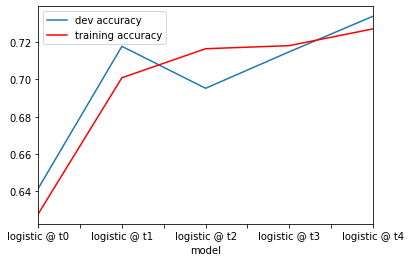

In [120]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### Random Forest 

##### Random Forest @ $t_0$

In [170]:
list(range(40,44,2))

[40, 42]

In [194]:
len(dem_var)

42

In [195]:
int(np.sqrt(len(var)))

7

In [172]:
list(range(25,350,25))

[25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325]

In [192]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)

parameters_rf = {'n_estimators':[100,100],'max_features':[1,int(np.sqrt(len(dem_var)))]}
rf = RandomForestClassifier(n_jobs=-1, random_state = random_state)

t0_rf_accuracy = run_model(model=rf,grid=parameters_rf,label='random forest @ t0')

accuracy_matrix = pd.DataFrame()
accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t0_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 6, 'n_estimators': 100}

accuracy on the dev set is: 0.6028476219327477

accuracy on the train set is: 0.9735434510308406

confusion matrix:

[[2882  419]
 [2203 1098]]

classification report:

              precision    recall  f1-score   support

           0       0.57      0.87      0.69      3301
           1       0.72      0.33      0.46      3301

    accuracy                           0.60      6602
   macro avg       0.65      0.60      0.57      6602
weighted avg       0.65      0.60      0.57      6602

the runtime is 0.23561349312464397 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.602848,0.973543


##### Random Forest @ $t_1$

In [198]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

parameters_rf = {'n_estimators':[5,5],'max_features':[7,int(np.sqrt(len(var)))]}

t1_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t1')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t1_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 7, 'n_estimators': 5}

accuracy on the dev set is: 0.8266129032258065

accuracy on the train set is: 0.9875112849834486

confusion matrix:

[[331  41]
 [ 88 284]]

classification report:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       372
           1       0.87      0.76      0.81       372

    accuracy                           0.83       744
   macro avg       0.83      0.83      0.83       744
weighted avg       0.83      0.83      0.83       744

the runtime is 0.019202454884847005 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.602848,0.973543
1,random forest @ t1,0.856183,1.000000
2,random forest @ t1,0.877688,1.000000
3,random forest @ t1,0.856183,0.993981
4,random forest @ t1,0.826613,0.987511


##### Random Forest @ $t_2$

In [181]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)

t2_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t2')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t2_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 40, 'n_estimators': 50}

accuracy on the dev set is: 0.849933598937583

accuracy on the train set is: 0.9998533079067038

confusion matrix:

[[711  42]
 [184 569]]

classification report:

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       753
           1       0.93      0.76      0.83       753

    accuracy                           0.85      1506
   macro avg       0.86      0.85      0.85      1506
weighted avg       0.86      0.85      0.85      1506

the runtime is 0.15364168882369994 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.559679,0.974085
1,random forest @ t1,0.861559,0.999549
2,random forest @ t2,0.849934,0.999853


##### Random Forest @ $t_3$

In [182]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)

t3_rf_accuracy = run_model(model=rf,grid=parameters_rf, label='random forest @ t3')

accuracy_matrix = accuracy_matrix.append(pd.DataFrame(t3_rf_accuracy), sort=False)
accuracy_matrix.reset_index(inplace=True,drop=True)
accuracy_matrix


the optimal parameters are: {'max_features': 40, 'n_estimators': 50}

accuracy on the dev set is: 0.8159366262814539

accuracy on the train set is: 1.0

confusion matrix:

[[1012   61]
 [ 334  739]]

classification report:

              precision    recall  f1-score   support

           0       0.75      0.94      0.84      1073
           1       0.92      0.69      0.79      1073

    accuracy                           0.82      2146
   macro avg       0.84      0.82      0.81      2146
weighted avg       0.84      0.82      0.81      2146

the runtime is 0.231103777885437 minutes


,model,dev accuracy,training accuracy
0,random forest @ t0,0.559679,0.974085
1,random forest @ t1,0.861559,0.999549
2,random forest @ t2,0.849934,0.999853
3,random forest @ t3,0.815937,1.000000


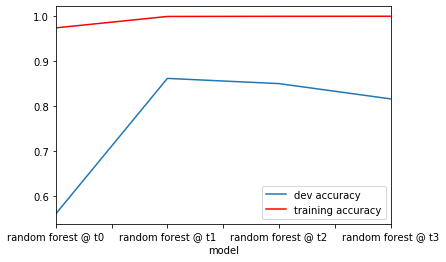

In [183]:
ax = plt.gca()

accuracy_matrix.plot(kind='line',x='model',y='dev accuracy',ax=ax)
accuracy_matrix.plot(kind='line',x='model',y='training accuracy', color='red', ax=ax)

plt.show()

### XGBoost

##### XGBoost @ $t_0$

In [184]:
def run_model_xgb(label,num_round):
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_dev = xgb.DMatrix(X_dev, label=y_dev)
    
    param = {'max_depth': 6, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(d_dev, 'eval'), (d_train, 'train')]

    bst = xgb.train(param, d_train, num_round, evallist, verbose_eval=False)
    
    y_dev_pred = (bst.predict(d_dev) > 0.5) * 1
    y_train_pred = (bst.predict(d_train) > 0.5) * 1
    p_pred = bst.predict(d_dev)
    cm = confusion_matrix(y_dev,y_dev_pred)
    dev_accuracy = accuracy_score(y_dev,y_dev_pred)
    train_accuracy = accuracy_score(y_train,y_train_pred)
    dev_f1 = f1_score(y_dev,y_dev_pred)
    train_f1 = f1_score(y_train,y_train_pred)
    dev_precision = precision_score(y_dev,y_dev_pred)
    train_precision = precision_score(y_train,y_train_pred)
    dev_recall = recall_score(y_dev,y_dev_pred)
    train_recall = recall_score(y_train,y_train_pred)
    dev_roc = roc_auc_score(y_dev,y_dev_pred)
    train_roc = roc_auc_score(y_train,y_train_pred)
    report = classification_report(y_dev,y_dev_pred)
    
    print ('\naccuracy on the dev set is: {}'.format(dev_accuracy))
    print ('\naccuracy on the train set is: {}'.format(train_accuracy))
    print ('\nconfusion matrix:\n\n {}'.format(cm))
    print ('\nclassification report:\n\n{}'.format(report))
    
    metrics = {'model':label,
               'dev accuracy':[dev_accuracy], 
               'training accuracy':[train_accuracy],
               'dev f1':[dev_f1],
               'training f1':[train_f1],
               'dev precision':[dev_precision],
               'training precision':[train_precision],
               'dev recall':[dev_recall],
               'training recall':[train_recall],
               'dev roc':[dev_roc],
               'training roc':[train_roc]
              } 
    
    predict = {'predicted dev values':[y_dev_pred],
               'predicted training values':[y_train_pred],
               'predicted probabilities':[p_pred],
               'confusion matrix':[cm],
               'classification report':[report]}
    
    return (metrics, predict)

In [185]:
X_train,y_train,X_dev,y_dev = seq_data(t=0, time_to_grad=4, features=dem_var)
metrics,_ = run_model_xgb('xgb@t0',1000)


accuracy on the dev set is: 0.564374431990306

accuracy on the train set is: 0.974017400724466

confusion matrix:

 [[2902  399]
 [2477  824]]

classification report:

              precision    recall  f1-score   support

           0       0.54      0.88      0.67      3301
           1       0.67      0.25      0.36      3301

    accuracy                           0.56      6602
   macro avg       0.61      0.56      0.52      6602
weighted avg       0.61      0.56      0.52      6602



In [186]:
acc_mat = accuracy_matrix_fn(pd.DataFrame(), metrics)
acc_mat

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.564374,0.974017,0.364279,0.974466,0.673753,0.957911,0.249621,0.991604,0.564374,0.974017


##### XGBoost @ $t_1$

In [187]:
X_train,y_train,X_dev,y_dev = seq_data(t=1, time_to_grad=4, features=var)

metrics,_ = run_model_xgb('xgb@t1',1000)


accuracy on the dev set is: 0.8682795698924731

accuracy on the train set is: 1.0

confusion matrix:

 [[335  37]
 [ 61 311]]

classification report:

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       372
           1       0.89      0.84      0.86       372

    accuracy                           0.87       744
   macro avg       0.87      0.87      0.87       744
weighted avg       0.87      0.87      0.87       744



In [188]:
acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat

,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.564374,0.974017,0.364279,0.974466,0.673753,0.957911,0.249621,0.991604,0.564374,0.974017
1,xgb@t1,0.868280,1.000000,0.863889,1.000000,0.893678,1.000000,0.836022,1.000000,0.868280,1.000000


##### XGBoost @ $t_2$

In [189]:
X_train,y_train,X_dev,y_dev = seq_data(t=2, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t2',750)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat


accuracy on the dev set is: 0.8625498007968128

accuracy on the train set is: 1.0

confusion matrix:

 [[676  77]
 [130 623]]

classification report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       753
           1       0.89      0.83      0.86       753

    accuracy                           0.86      1506
   macro avg       0.86      0.86      0.86      1506
weighted avg       0.86      0.86      0.86      1506



,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.564374,0.974017,0.364279,0.974466,0.673753,0.957911,0.249621,0.991604,0.564374,0.974017
1,xgb@t1,0.868280,1.000000,0.863889,1.000000,0.893678,1.000000,0.836022,1.000000,0.868280,1.000000
2,xgb@t2,0.862550,1.000000,0.857536,1.000000,0.890000,1.000000,0.827357,1.000000,0.862550,1.000000


##### XGBoost @ $t_3$

In [190]:
X_train,y_train,X_dev,y_dev = seq_data(t=3, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t3',1000)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat


accuracy on the dev set is: 0.8392357875116496

accuracy on the train set is: 1.0

confusion matrix:

 [[949 124]
 [221 852]]

classification report:

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1073
           1       0.87      0.79      0.83      1073

    accuracy                           0.84      2146
   macro avg       0.84      0.84      0.84      2146
weighted avg       0.84      0.84      0.84      2146



,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.564374,0.974017,0.364279,0.974466,0.673753,0.957911,0.249621,0.991604,0.564374,0.974017
1,xgb@t1,0.868280,1.000000,0.863889,1.000000,0.893678,1.000000,0.836022,1.000000,0.868280,1.000000
2,xgb@t2,0.862550,1.000000,0.857536,1.000000,0.890000,1.000000,0.827357,1.000000,0.862550,1.000000
3,xgb@t3,0.839236,1.000000,0.831625,1.000000,0.872951,1.000000,0.794035,1.000000,0.839236,1.000000


##### XGBoost @ $t_4$

In [191]:
X_train,y_train,X_dev,y_dev = seq_data(t=4, time_to_grad=4, features=var)
metrics,_ = run_model_xgb('xgb@t4',1000)

acc_mat = accuracy_matrix_fn(acc_mat,metrics)
acc_mat


accuracy on the dev set is: 0.830970942593905

accuracy on the train set is: 1.0

confusion matrix:

 [[1240  171]
 [ 306 1105]]

classification report:

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1411
           1       0.87      0.78      0.82      1411

    accuracy                           0.83      2822
   macro avg       0.83      0.83      0.83      2822
weighted avg       0.83      0.83      0.83      2822



,model,dev accuracy,training accuracy,dev f1,training f1,dev precision,training precision,dev recall,training recall,dev roc,training roc
0,xgb@t0,0.564374,0.974017,0.364279,0.974466,0.673753,0.957911,0.249621,0.991604,0.564374,0.974017
1,xgb@t1,0.868280,1.000000,0.863889,1.000000,0.893678,1.000000,0.836022,1.000000,0.868280,1.000000
2,xgb@t2,0.862550,1.000000,0.857536,1.000000,0.890000,1.000000,0.827357,1.000000,0.862550,1.000000
3,xgb@t3,0.839236,1.000000,0.831625,1.000000,0.872951,1.000000,0.794035,1.000000,0.839236,1.000000
4,xgb@t4,0.830971,1.000000,0.822479,1.000000,0.865987,1.000000,0.783133,1.000000,0.830971,1.000000
